                        type  Cantidad
1                     Choque    2379.0
0               Autolesiones     100.0
3  Choque contra objeto fijo      58.0
4                Volcamiento      14.0
2     Choque con volcamiento       4.0
['At 10:00 hours, the most frequent accidents are Choque and Autolesiones, with a total amout of 2379.0 and 100.0 cases.']


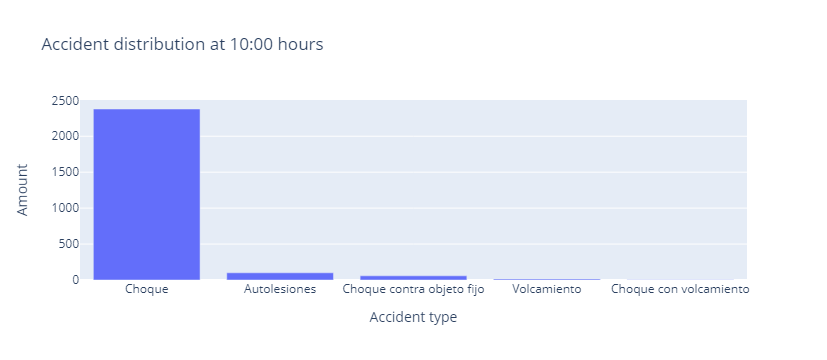

In [42]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sklearn.cluster import DBSCAN 
from math import radians

class Insights:
    
    def __init__(self):
        self.incidents = None
        self.incidents_implicated = None
        self.siniestros = None
        self.gdf = None
        
        self.cargarDatasets()
        self.inicializarDatasets()
        self.procesarDatasets()
        self.cargarPoligonos()
        
    def cargarDatasets(self):
        self.incidents = pd.read_csv("../0_datasets/processed/incidents.csv.gz", parse_dates=["incident_time"])
        self.incidents_implicated = pd.read_csv("../0_datasets/processed/incidents_implicated.csv.gz")
        
    def inicializarDatasets(self):
        self.siniestros = self.incidents[self.incidents["class"] == "Siniestro"]        
        self.siniestros= self.siniestros.merge(self.incidents_implicated,
                                            how="left", left_on="id",
                                            right_on="incident_id").drop(columns=["id_y", "incident_id"])\
                                                                   .rename(columns={"id_x":"id"})\
                                                                   .drop_duplicates(subset="id")\
                                                                   .sort_values("incident_time")
    def cargarPoligonos(self):
        self.pol = gpd.read_file("../0_datasets/processed/poligonos_bog.geojson")
        
    
    def procesarDatasets(self):
        self.siniestros["incident_day"] = self.siniestros.loc[:, "incident_time"].dt.to_period("d").dt.to_timestamp()
        self.siniestros["hour"] = self.siniestros["incident_time"].dt.hour
                
    #1. El mayor tipo de accidente
    def mayor_tipo_accidente(self):
        data = self.siniestros["type"].value_counts()    
        insights = []

        insights.append("The incident type with the most amount of cases is "+str(data.index[0])+" with a total of "+str(data[0]))        
        grafico = px.bar(data, x=data.index, y=data, title="Biggest incident types",labels={'index':'Incident type','y':'Value'})
        return data, grafico, insights
    
    #2. Las localidades con mayor cantidad de accidentes
    def cantidad_accidentes_por_localidad(self):        
        data = self.siniestros["location"].value_counts().reset_index().rename(columns={"index":"localidad", "location": "num_siniestros"}).drop(19)
        pol_copy = self.pol
        data_chlo = pol_copy.merge(data,how="left", on="localidad").set_index("localidad")

        grafico = px.choropleth_mapbox(data_chlo,
                                geojson=data_chlo.geometry,
                                locations=data_chlo.index,
                                color="num_siniestros",
                                    center={'lat': 4.601981275958889, 'lon': -74.0767720598354},
                                mapbox_style="open-street-map",
                                color_continuous_scale=["green","red"],
                                zoom=10,
                                height=800
                                )

        insights=[]    
        insights.append("The location with more accidents is "+str(data.iloc[0][0])+" with a total amount of "+str(data.iloc[0][1])+" cases, followed by "+str(data.iloc[1][0])+" and "+str(data.iloc[2][0])+" with "+str(data.iloc[1][1])+" and "+str(data.iloc[2][1])+" cases respectively")    
        #grafico = px.bar(data, x="index", y="total", color="tipo", title="Deaths per accident",labels={'index':'# of deaths','total':'Value','tipo':'Category'})    
        return data, grafico, insights

    #3. Cantidad de accidentes con muertes
    def cantidad_accidentes_con_muertos(self):
        data_muertos = self.siniestros["dead_count"].value_counts().to_frame()
        data_muertos["tipo"],data_muertos["total"] = "Muertos",data_muertos["dead_count"]
        data = data_muertos
        del data["dead_count"]
        data.reset_index(inplace=True)    
        data = data[(data["index"] > 0)]
        insights=[]
        insights.append(str(data["total"].sum())+" people died because of the accidents")    
        grafico = px.bar(data, x="index", y="total", color="tipo", title="Deaths per accident",labels={'index':'# of deaths','total':'Value','tipo':'Category'})    
        return data, grafico, insights
    
    #4. Cantidad de accidentes con heridos
    def cantidad_accidentes_con_heridos(self):
        data_heridos = self.siniestros["injured_count"].value_counts().to_frame()
        data_heridos["tipo"],data_heridos["total"] = "Heridos",data_heridos["injured_count"]
        data = data_heridos
        del data["injured_count"]
        data.reset_index(inplace=True)    
        data = data[(data["index"] > 0)]
        insights=[]
        insights.append(str(data["total"].sum())+" people got injuries as result of the accidents")    
        grafico = px.bar(data, x="index", y="total", color="tipo", title="Injuries per accident",labels={'index':'# of injuries','total':'Value','tipo':'Category'})    

        return data, grafico, insights
    
    #5. Vehiculos con mayor presencia en accidentes
    def accidentes_por_tipo_vehiculo(self):
        data = self.siniestros["implicated_type"].value_counts()
        insights=[]    
        insights.append("The type of vehicle with the most amount of accidents is "+str(data.index[0])+", followed by "+str(data.index[1])+" and "+str(data.index[2])+", with a total amount of "+str(data.values[0])+", "+str(data.values[1])+" and "+str(data.values[2])+" cases respectively.")
        grafico = px.bar(data, x=data.index, y=data,labels={'index':'Type of vehicle','y':'Amount'}, title="Accidents per vehicle type")

        return data, grafico, insights
    
    #6. El mayor tipo de accidente por zona
    def tipo_accidentes_por_localidad(self):        
        data = self.siniestros[["type","location"]].value_counts().reset_index().rename(columns={"index":"localidad", "location": "localidad","0":"total"})    
        data = data[data["localidad"] != "LOCATION MISSING"]
        data["total_accidentes"]=data[0]
        del data[0]

        data_final = pd.DataFrame(columns = ["localidad"])
        data.sort_values(by=['total_accidentes'],ascending=False,inplace=True)
        for localidad in data["localidad"].value_counts().index:        
            data_final = pd.concat([data_final,data[data["localidad"] == localidad].iloc[[0]]])

        pol_copy = self.pol
        data_chlo = pol_copy.merge(data_final,how="left", on="localidad").set_index("localidad")

        hover = [x for x in data_chlo["type"].value_counts().index]

        grafico = px.choropleth_mapbox(data_chlo,
                                geojson=data_chlo.geometry,
                                locations=data_chlo.index,
                                color="total_accidentes",
                                    center={'lat': 4.601981275958889, 'lon': -74.0767720598354},
                                mapbox_style="open-street-map",
                                hover_data=["type"],
                                color_continuous_scale=["green","red"],
                                zoom=10,
                                height=800
                                )
        insights=[]    
        insights.append("The location with more accidents is "+str(data_final.iloc[0][0])+" with a total amount of "+str(data_final.iloc[0][2])+" cases of type "+str(data_final.iloc[0][1])+", followed by "+str(data_final.iloc[1][0])+" with "+str(data_final.iloc[1][2])+" cases of type "+str(data_final.iloc[1][1]))    
        insights.append("The location with less accidents is "+str(data_final.iloc[-1][0])+" with a total amount of "+str(data_final.iloc[-1][2])+" cases of type "+str(data_final.iloc[-1][1]))    
        return data_final, grafico, insights
    
    #7. Zonas con mayor accidentalidad por hora
    def cantidad_accidentes_por_localidad_hora(self,hora):          
        data = self.siniestros[["location","hour"]].value_counts().reset_index().rename(columns={"index":"localidad", "location": "localidad","0":"total"})    
        data = data[data["localidad"] != "LOCATION MISSING"]
        data["total_accidentes"]=data[0]
        data = data[data["hour"] == hora]
        data.reset_index(inplace=True)
        del data[0],data["hour"],data["index"]

        pol_copy = self.pol
        data_chlo = pol_copy.merge(data,how="left", on="localidad").set_index("localidad")

        grafico = px.choropleth_mapbox(data_chlo,
                                geojson=data_chlo.geometry,
                                locations=data_chlo.index,
                                color="total_accidentes",
                                    center={'lat': 4.601981275958889, 'lon': -74.0767720598354},
                                mapbox_style="open-street-map",   
                                color_continuous_scale=["green","red"],                         
                                zoom=10,
                                height=800
                                )
        insights=[]    
        insights.append("The location with more accidents at * is "+str(data.iloc[0][0])+" with a total amount of "+str(data.iloc[0][1])+" cases")    
        insights.append("The location with less accidents at * is "+str(data.iloc[-1][0])+" with a total amount of "+str(data.iloc[-1][1])+" cases")    
        return data, grafico, insights
    
    #8. Distribución de prioridades en los accidentes
    def accidentes_por_prioridad(self):
        data = self.siniestros["priority"].value_counts()
        insights=[]   
        insights.append( "The most frequent priority for accidents is "+str(data.index[0])+", followed by "+str(data.index[1])+", with an amount of "+str(data.values[0])+" and "+str(data.values[1])+" cases each.")
        grafico = px.bar(data, x=data.index, y=data,labels={'index':'Priority','y':'Amount'}, title="Accidents per priority")

        return data, grafico, insights
    
    #9. El mayor tipo de accidente por hora
    def cantidad_accidentes_por_hora(self,hora):
        data = self.siniestros[["hour","type"]].value_counts().sort_values().sort_index(kind='mergesort')
        data = data.unstack(level=0).reset_index()[["type",hora]].fillna(0)    
        #print(data["type"].to_frame().index)
        data = pd.merge(data["type"], data[hora], right_index = True,left_index = True)
        data.rename(columns={hora: "Cantidad"},inplace=True)
        data.sort_values(by="Cantidad",ascending=False,inplace=True)

        horaEnTexto = ("0"+str(hora) if hora < 10 else str(hora))+":00"
        insights=[]

        insights.append("At "+horaEnTexto+" hours, the most frequent accidents are "+str(data.iloc[0][0])+" and "+str(data.iloc[1][0])+", with a total amout of "+str(data.iloc[0][1])+" and "+str(data.iloc[1][1])+" cases.")
        grafico = px.bar(data, x=data["type"], y=data["Cantidad"],labels={'type':'Accident type','Cantidad':'Amount'}, title="Accident distribution at "+horaEnTexto+" hours")

        return data, grafico, insights
    
    
    
        
        
"""        
insights = Insights()
lista = insights.cantidad_accidentes_por_hora(10)
print(lista[0])
print(lista[2])
lista[1].show()
"""